# Twitter Data Analysis.

Extracting Twitter data , Pre-processing and Mining for trending keywords.

With the current COVID-19 pandemic consequences we tried to understand how "recession" is trending over twitter.

In [64]:
import requests
import base64
import nltk
import requests
from nltk.corpus import twitter_samples
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import naive_bayes
import re 
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')
#nltk.download('twitter_samples')

Twitter API Connection.

In [65]:
def search_data_twitter(my_search_term):
    client_key = 'XXXX'
    client_secret = 'XXXX'

    key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
    b64_encoded_key = base64.b64encode(key_secret)
    b64_encoded_key = b64_encoded_key.decode('ascii')

    base_url = 'https://api.twitter.com/'
    auth_url = '{}oauth2/token'.format(base_url)

    auth_headers = {
        'Authorization': 'Basic {}'.format(b64_encoded_key),
        'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
    }

    auth_data = {
        'grant_type': 'client_credentials'
    }

    auth_resp = requests.post(auth_url, headers=auth_headers, data=auth_data)
    print("Status :",auth_resp.status_code)

    access_token = auth_resp.json()['access_token']

    search_headers = {
        'Authorization': 'Bearer {}'.format(access_token)    
    }

    search_params = {
        'q': my_search_term,
        'result_type': 'recent',
        'count': 100,
        'tweet_mode':'extended',
        'retweeted':'False',
        'iso_language_code': 'en'
    }

    search_url = '{}1.1/search/tweets.json'.format(base_url)

    search_resp = requests.get(search_url, headers=search_headers, params=search_params)
    
    return search_resp

    

In [66]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)

Analyzing the trends in "recession" on Twitter.

In [67]:
data = search_data_twitter('recession')
tweet_data = data.json()

Status : 200


In [68]:
my_tweets = []
for x in tweet_data['statuses']:
    my_tweets.append(x['full_text'])

In [69]:
def clean_data(my_tweets):
    tweet_list = []
    for i in my_tweets:
        proc_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                        '(?:%[0-9a-fA-F][0-9a-fA-F]))+','',i)

        proc_tweet = re.sub("(@[A-Za-z0-9_]+)","", proc_tweet)
    
        proc_tweet = proc_tweet.lower()
   
        proc_tweet = re.sub(r'\W', ' ', proc_tweet)

        proc_tweet = re.sub(r'\s+', ' ', proc_tweet, flags=re.I)

        proc_tweet = proc_tweet.replace('rt','')

        proc_tweet = re.findall(r'\w+', proc_tweet) 
        
        tweet_list.append(proc_tweet)
    
    return tweet_list

In [70]:
my_tweets_freq_count = my_tweets.copy()

In [71]:
my_tweets_freq_count = clean_data(my_tweets_freq_count)

Analyzing Word Frequency.

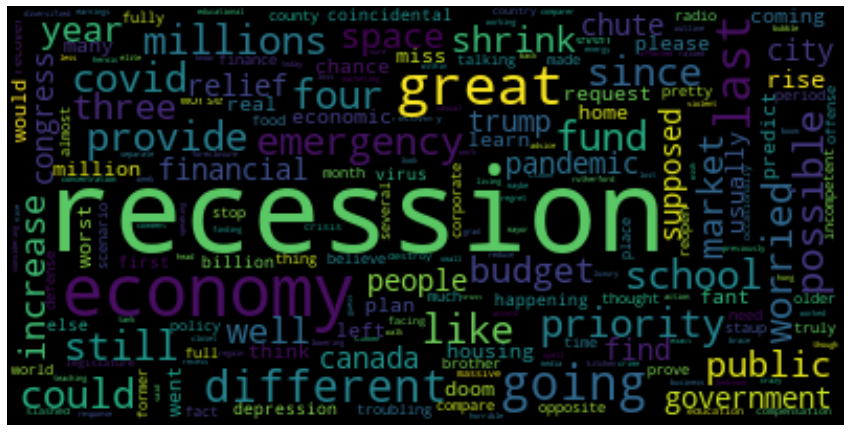

In [72]:

import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk import FreqDist
from wordcloud import WordCloud
from matplotlib import pyplot as plt

words = set(nltk.corpus.words.words())
my_clean_list=[]
for i in my_tweets_freq_count:
    for j in i:
        if (j not in stopwords.words('english') and (j in words) and len(j) > 3):
            my_clean_list.append(j)
        
#frequency count
freq_dist_pos = FreqDist(my_clean_list)

wcloud = WordCloud().generate_from_frequencies(freq_dist_pos)
plt.figure(figsize=(15,16))
plt.imshow(wcloud, interpolation="bilinear")
 
plt.axis("off")
(-0.5, 499.5, 499.5, -0.5)
plt.show()

In [73]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [74]:
tweet_3 = pd.DataFrame(my_tweets,columns=['Tweets'])
tweet_3['Real_Tweets']=tweet_3['Tweets']

In [75]:
#removing the tweets username.
tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "@[\w]*")
#removing all the RT: text from the Tweets.
tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "RT :")

tweet_3['Tweets'] = tweet_3['Tweets'].str.replace('[^a-zA-Z#]',' ')

tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "\n")

tweet_3['Tweets'] = np.vectorize(remove_pattern)(tweet_3['Tweets'], "r'^https?:\/\/.*[\r\n]*'")

#removing the emoticons
tweet_3['Tweets'] = tweet_3['Tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

tweet_3['Tweets_len'] = tweet_3['Tweets'].apply(len)

#removing tweets totally in different languages
drop_tweets = tweet_3[tweet_3['Tweets_len'] == 0].index

tweet_3.drop(index=drop_tweets,inplace=True)

#drop duplicates
tweet_3.drop_duplicates(subset=['Tweets'], keep = 'first',inplace= True)

In [76]:
tweet_3

,Tweets,Real_Tweets,Tweets_len
0,VideoAsk Heroic Public Speaking Recession Resp...,"VideoAsk, Heroic Public Speaking, Recession Re...",105
1,rise mortgage delinquencies during month when ...,RT @seattletimes: The rise in mortgage delinqu...,100
2,this article fucking horrible even know where ...,lol this article is so fucking horrible I don'...,57
3,pretty sure Wilson County Rutherford County Co...,@603Freeman @BadBradjams @Fakejeffwoods I’m pr...,139
4,Budget forecasters Britain economy could shrin...,"RT @randombigbird: ""Budget forecasters say Bri...",91
5,request please increase fees pawar school hinj...,RT @Imranghumara: @bhaveshkvyas @VarshaEGaikwa...,61
7,think pretty crazy bonds Dalio talking about w...,"RT @lisaabramowicz1: ""I think you'd be pretty ...",60
8,truly hoping that this recession about walk in...,I’m truly hoping that this recession we are ab...,172
9,Worried about recession Your emergency fund sh...,RT @CNBC: Worried about a recession? Your emer...,88
10,BofA Donofrio said possible there could recess...,RT @lisaabramowicz1: BofA CFO Donofrio said it...,74


NLP <br>
Preparing data for vectorization.<br>
Vectorization is a methology of converting the words into real numbers which is used to find the word similarities.

In [77]:
stopset = set(stopwords.words('english'))
desc = tweet_3['Tweets'].values
vectorizer = TfidfVectorizer(stop_words = stopset)
X = vectorizer.fit_transform(desc)

In [78]:
word_features = vectorizer.get_feature_names()

K means Clustering.

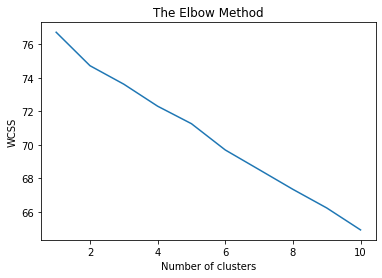

In [79]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='random',max_iter=500,n_init=10,random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

In [80]:
kmeans = KMeans(n_clusters = 5, n_init = 20, n_jobs = 1)
kmeans.fit(X)
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]

Clustering of Data to understand the similarity in the keywords.

In [81]:
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features[word] for word in centroid))
    print("")

0 : great, still, recession, since, city, worst, depression, first, quarter, plan, home, draftvaluersbill, developed, predicts, years, https, government, world, gdp, million, crise, faut, corporate, useconomy, different

1 : recession, economy, rigged, smoked, canada, much, heard, radio, coronavirus, deepest, could, viralrecession, useconomy, serious, expected, well, happening, worse, destroy, years, truly, last, full, virus, industries

2 : going, like, usually, recession, would, market, time, month, happens, opposite, troubling, delinquencies, mortgage, start, rise, housing, county, complaining, financially, wiped, press, coming, left, pandemic, confusing

3 : https, recession, espshai, financial, startup, offense, defense, learn, crisis, jobs, policy, covid, space, stop, fvfvspc, qvwyqe, article, horrible, fucking, know, years, tapi, bwzwtcjvoh, emergency, worried

4 : school, pawar, please, hinjewadi, fees, many, request, increase, pune, facing, massive, advice, wvlp, considering, 